In [1]:
from google.colab import files 
uploaded = files.upload()

Saving aapl.us.txt to aapl.us.txt


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

stock = "aapl"
#follows the stock file name
df = pd.read_csv('aapl.us.txt')

In [3]:
data_count = 30
parameter = "fixed_instances_" + str(data_count)

In [4]:
#We parse the date to the correct format
df['Date'] = pd.to_datetime(df['Date'])

# Extract only closing price
df_daily = df.reset_index()['Close']

In [5]:
#creating another date column for month, year and quarter so we can 'groupby' later
df['month'] = df['Date'].dt.to_period("M")
df['year'] = df['Date'].dt.to_period("Y")
df['quarter'] = df['Date'].dt.quarter

#df for Monthly
df_monthly = df.groupby(['month']).agg(
    mean_open = pd.NamedAgg(column='Open', aggfunc='mean'),
    mean_high = pd.NamedAgg(column='High', aggfunc='mean'),
    mean_low = pd.NamedAgg(column='Low', aggfunc='mean'),
    mean_close = pd.NamedAgg(column='Close', aggfunc='mean'),
    mean_volume = pd.NamedAgg(column='Volume', aggfunc='mean')
)

#df for Quarterly 
df_quarterly = df.groupby(['year', 'quarter']).agg(
    mean_open = pd.NamedAgg(column='Open', aggfunc='mean'),
    mean_high = pd.NamedAgg(column='High', aggfunc='mean'),
    mean_low = pd.NamedAgg(column='Low', aggfunc='mean'),
    mean_close = pd.NamedAgg(column='Close', aggfunc='mean'),
    mean_volume = pd.NamedAgg(column='Volume', aggfunc='mean')
)

# Cutting to latest 100
df_daily = df_daily[len(df_daily) - data_count:].reset_index()['Close']
df_monthly = df_monthly[len(df_monthly) - data_count:].reset_index()['mean_close']
df_quarterly = df_quarterly[len(df_quarterly) - data_count:].reset_index()['mean_close']

#print(df_daily)

In [6]:
#Change here
#df_daily, df_monthly, df_quarterly
df_in_use = df_daily  
#saving data
season = "daily"

In [7]:
#print(training_data_pre_normalized)

In [8]:
# Splitting to train and test split, 70-30 split
training_size = int(len(df_in_use) * 0.7)
test_size = len(df_in_use) - training_size 
training_data_pre_normalized = df_in_use[:training_size]
testing_data_pre_normalized = df_in_use[training_size:].reset_index()['Close'] if season == "daily" else df_in_use[training_size:].reset_index()['mean_close']
#print(training_data_pre_normalized)

In [9]:
# Define a function that breaks the information this way
# Suppose closing prices are [100, 110, 120, 130, 140, 150], timestep = 3
# Label depends on previous 3 days
#    X_train      y_train
# 100, 110, 120     130
# 110, 120, 130     140

def create_stepped_dataset(dataset, timestep=1):
  dataX, dataY = [], []
  for i in range(len(dataset)- timestep):
    features = dataset[i: (i + timestep)]
    dataX.append(features)
    label = dataset[i + timestep]
    dataY.append(label)
  return np.array(dataX), np.array(dataY)

In [10]:
# Pre-process data, normalized
time_step = 3
X_train_pre_normalized, y_train_pre_normalized = create_stepped_dataset(training_data_pre_normalized, time_step)
X_test_pre_normalized, y_test_pre_normalized = create_stepped_dataset(testing_data_pre_normalized, time_step)


In [11]:
print(y_test_pre_normalized)

[171.88 173.63 174.18 175.61 175.25 174.67]


In [12]:
# Normalizing closing values since LSTM are sensitive to scale of data
# Keep it from [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
training_data = scaler.fit_transform(np.array(training_data_pre_normalized).reshape(-1,1))
testing_data = scaler.fit_transform(np.array(testing_data_pre_normalized).reshape(-1,1))

In [13]:
X_train, y_train = create_stepped_dataset(training_data, time_step)
X_test, y_test = create_stepped_dataset(testing_data, time_step)

In [14]:
def flatten_data(data):
    o = []
    for d in data:
        b = list(d.flatten())
        o.append(b)
    return o

Text(0, 0.5, 'aapl Stock Price')

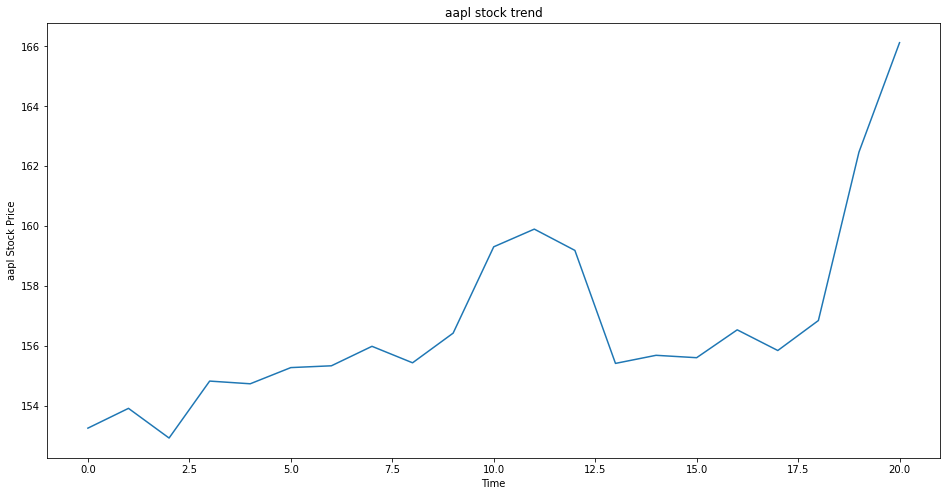

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(training_data_pre_normalized)

plt.title('{} stock trend'.format(stock))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock))


In [16]:
# Create Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [17]:
model = Sequential()
# First layer need to take in specified #features
model.add(LSTM(50, return_sequences=True, input_shape=(3,1))) #Change here if need edit timestep due to lack of data
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 3, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Training the data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.1588
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 0.1530
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1473
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1416
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.1357
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.1297
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 0.1235
Epoch 8/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1172
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 0.1107
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 0.1041
Epoch 11/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0974
Epoch 12/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0906
Epoch 13/100
1/1 [==============================] -

In [20]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [21]:
# Transforming back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [22]:
#print(test_predict)
#print(y_test_pre_normalized)

In [23]:
# Calculating performance metrics [abso]
import math
from sklearn.metrics import mean_squared_error
MSE_training = mean_squared_error(y_train_pre_normalized, train_predict)
MSE_testing = mean_squared_error(y_test_pre_normalized, test_predict)
RMSE_training = math.sqrt(MSE_training)
RMSE_testing = math.sqrt(MSE_testing)
stats = 'MSE_training = {}, MSE_testing = {}\nRMSE_training = {}, RMSE_testing = {}'.format(MSE_training, MSE_testing, RMSE_training, RMSE_testing)
stats_array = np.array(['MSE_training = {}, MSE_testing = {}'.format(MSE_training, MSE_testing),
                       'RMSE_training = {}, RMSE_testing = {}'.format(RMSE_training, RMSE_testing)])
print(stats)

MSE_training = 154.3396917264079, MSE_testing = 15.95803233813073
RMSE_training = 12.423352676568749, RMSE_testing = 3.994750597738328


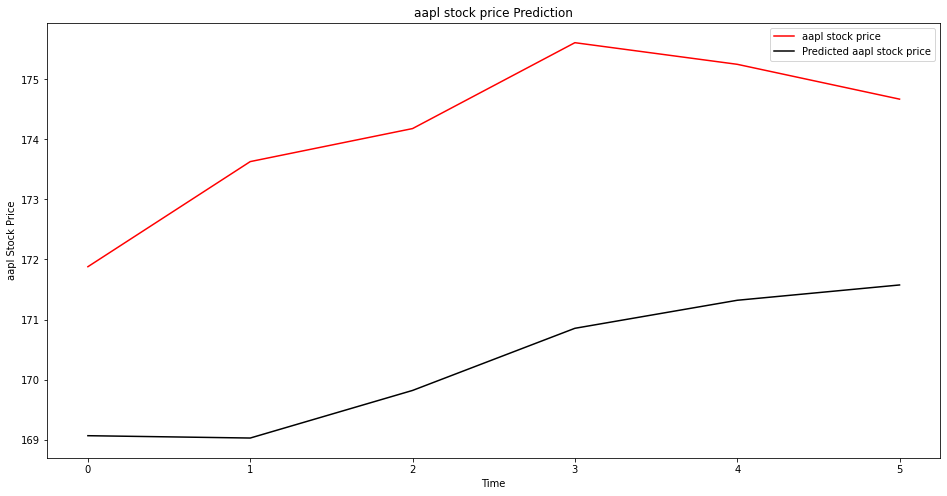

In [24]:
# Plotting the data
plt.figure(figsize=(16, 8))

plt.plot(y_test_pre_normalized, color = 'red', label = '{} stock price'.format(stock))
plt.plot(test_predict, color = 'black', label = 'Predicted {} stock price'.format(stock))
plt.title('{} stock price Prediction'.format(stock))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock))
plt.legend()

In [25]:
# Calculating mean of y